In [35]:
import petpy
import pandas as pd
import urllib.request
from urllib.error import HTTPError
import time
from datetime import date
import os
from tqdm import tqdm_notebook
from ast import literal_eval
from multiprocessing.pool import ThreadPool
import re

In [ ]:
# Replace xx with API key and secret
pf = petpy.Petfinder(key='xx', 
                     secret='xx')

In [ ]:
# Skips fetching new data if old csv file is present
today_only = False

breeds = pf.breeds('cat', return_df=True).name

# Define a downloader function
This function downloads images, exceptions does not raise errors but gently skips this image.

In [ ]:
def downloader(filename, image_url):
    pet_id = filename.split('\\')[1].split('_')[0]
    if pet_id not in downloaded_images_id:
        full_file_name = filename + '.jpg'
        try:
            urllib.request.urlretrieve(image_url,full_file_name)
        except (HTTPError, OSError):
            return

# Breed Collector
> As we are trying to build a balanced dataset, we need to get enough images of all cat breeds. If we didn't pass a specific breed to fetch from PetFinder, we will get very few records from rare breeds as they are just drawn following a uniform distribution.

> To overcome this, we will loop through every breed and pass it in the call itself, with max pages = 75 and 100 record per page. This does not generate the number of images as some listings does not have images at all and others have more than one image.

> If the available records are less than 75, we will get them all.

> If csv files is already found, skip getting new one to avoid duplicate meaningless calls.

> If animal id is identified in the images already downloaded, skip downloading the image.

> Multithreading is used to accelerate downloading, without it the process could be really slow.

In [ ]:
for breed in breeds:
    csv_file = 'cats_{}_{}.csv'.format(breed.replace('/', '-'), date.today().strftime("%b-%d-%Y"))
    r = re.compile('cats_{}_.*\.csv'.format(breed.replace('/', '-')))

    if os.path.exists(csv_file):
        print('Found a csv file for today already, skipping api calls to PetFinder..')
        pure_cats_w_photos = pd.read_csv(csv_file)
        pure_cats_w_photos['med_photos'] = pure_cats_w_photos.med_photos.apply(literal_eval)
    elif list(filter(r.match, filter(os.path.isfile, os.listdir('.')))) and not today_only:
        print('Found a old csv file already while today_only is set to False, skipping api calls to PetFinder..')
        csv_file = list(filter(r.match, filter(os.path.isfile, os.listdir('.'))))[0]
        pure_cats_w_photos = pd.read_csv(csv_file)
        pure_cats_w_photos['med_photos'] = pure_cats_w_photos.med_photos.apply(literal_eval)
    else:
        print('Creating {} csv file...'.format(breed))
        cats = pf.animals(results_per_page=100, pages=75, return_df=True, 
                          animal_type='cat', breed=breed)
        # Filter pure cats only
        pure_cats_w_photos = cats[(~cats['breeds.mixed']) & (~cats['breeds.unknown']) & 
                                  (cats['breeds.secondary'].isna()) & ~cats['breeds.primary'].isna() & 
                                  cats['photos']][['id', 'url', 'type', 'age', 'gender', 
                                          'size', 'coat', 'breeds.primary', 'photos']]

        pure_cats_w_photos.rename(columns={'breeds.primary': 'breed'}, inplace=True)
        pure_cats_w_photos['med_photos'] = pure_cats_w_photos.photos.apply(lambda photos: [photo['medium'] for photo in photos])
        pure_cats_w_photos['breed'] = pure_cats_w_photos.breed.str.replace('/', '-')
        pure_cats_w_photos.to_csv(csv_file, index=False)
        
    image_urls = []
    img_dir_names = []
    downloaded_images_id = []

    for my_folder in pure_cats_w_photos.breed.unique():
        if not os.path.exists(my_folder):
            os.makedirs(my_folder)

    for ix, row in pure_cats_w_photos.iterrows():
        for photo_url in row.med_photos:
            image_urls.append(photo_url)
            img_dir_names.append(r'{breed}\{id}_{ix}'.format(breed=row.breed, ix=ix, id=row.id))

    for dirname, _, filenames in os.walk('.'):
        for filename in filenames:
            if filename.endswith('.jpg'):
                downloaded_images_id.append(filename.strip('.jpg').split('_')[0])

    %time Downloader = ThreadPool(32).starmap(downloader, zip(img_dir_names, image_urls))

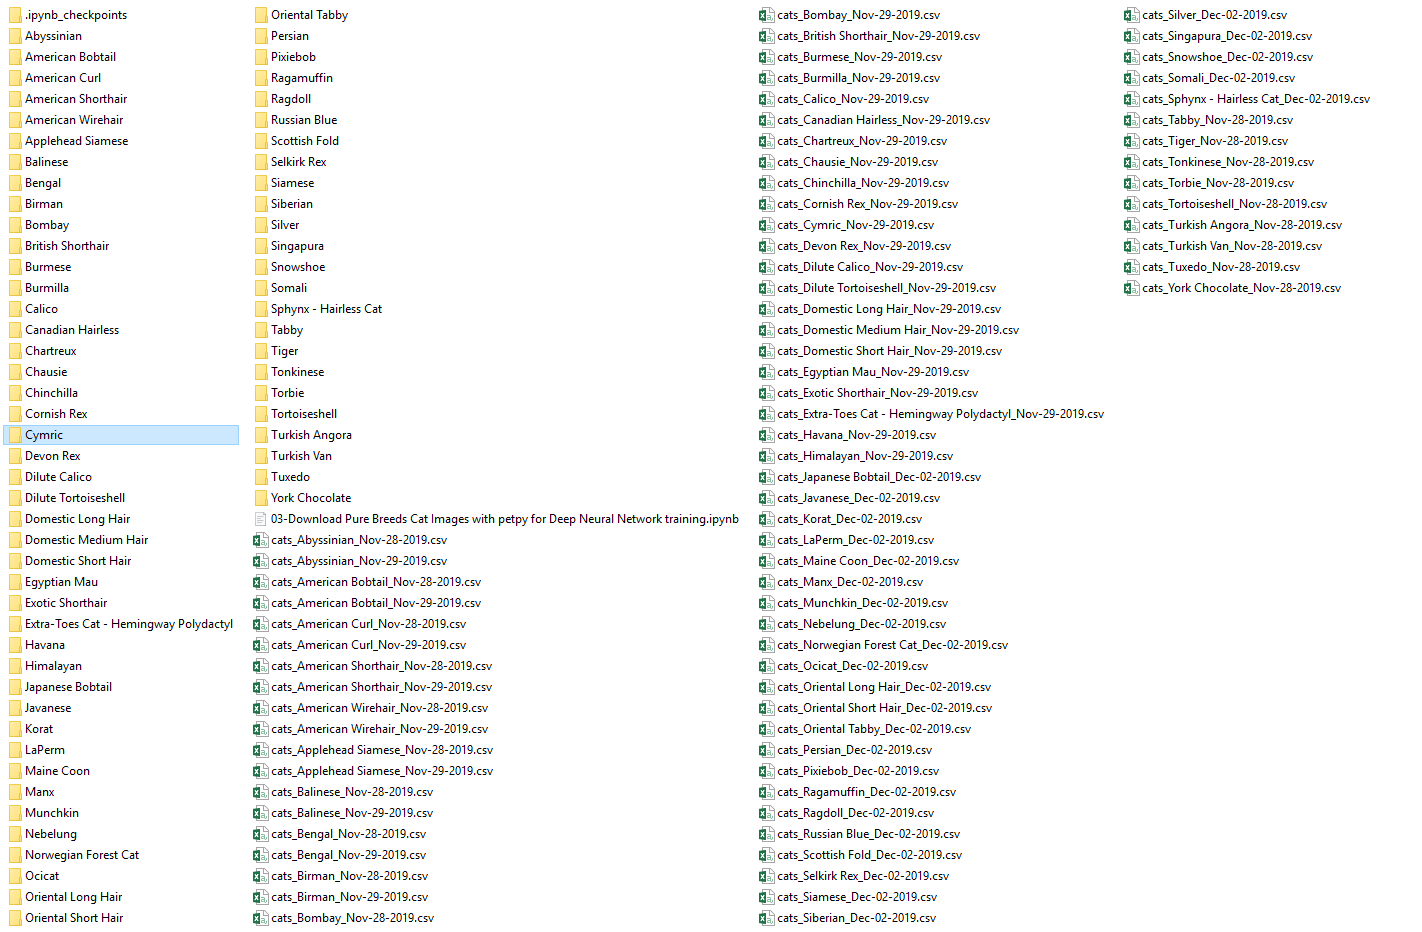